# Natural Images classifier tutorial 

## 1) Take a look at sample of the data

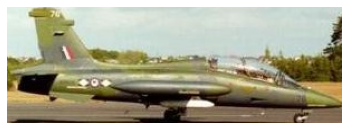

(104, 300, 3)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from os import walk
import keras
DATADIR = "C:\\Users\\$0My\\Desktop\\Natural_Images_Classifier-master\\data\\natural_images"


f = []
for (dirpath, dirnames, filenames) in walk(DATADIR):
    f.extend(dirnames)
    break

for category in f:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img))  # convert to array
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        plt.imshow(img_array)  # graph it
        plt.axis("off")
        plt.show()  # display!

        break  # we just want one for now so break
    break
img_array.shape

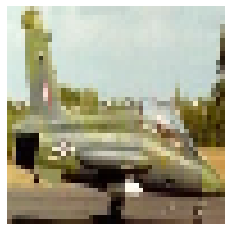

In [ ]:
IMG_SIZE = 48

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.axis("off")
plt.show()


## 2) Load the Data

In [ ]:
training_data = []

def create_training_data():
    for category in f: 

        path = os.path.join(DATADIR,category) 
        for img in tqdm(os.listdir(path)): 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE) 
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                training_data.append([new_array, category])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 986/986 [00:02<00:00, 355.37it/s]

6899


In [ ]:
import random

random.shuffle(training_data)

In [ ]:
for sample in training_data[:10]:
    print(sample[1])

car
dog
cat
airplane
car
person
dog
motorbike
cat
cat


## 3) Visualize the dataset

In [ ]:
def show_batch(image_batch,label_batch): # see a batch of  the  data to better understand it
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n], cmap='gray')
        plt.title(label_batch[n])
        plt.axis("off")

6899
(6899, 1)
[['car']
 ['dog']
 ['cat']
 ...
 ['cat']
 ['flower']
 ['dog']]
(6899, 8) (6899, 48, 48, 1)


C:\annaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


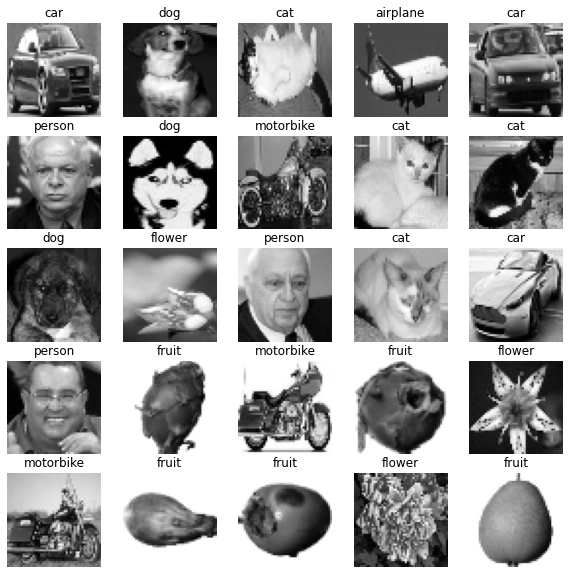

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

X = []
y = []
print(len(training_data))
for features,label in training_data:
    X.append(features)
    y.append(label)
show_batch(X,y)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y=np.array(y).reshape(-1, 1)
print(y.shape)
print(y)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

y=to_categorical(y)
print(y.shape,X.shape)

In [ ]:
def show_batch_predicted(image_batch): # see the same batch after prediction from the model
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n], cmap='gray')
        pred=model.predict(np.array(image_batch[n]).reshape(1, IMG_SIZE, IMG_SIZE, 1))
        label=np.argmax(pred,axis=1)
        if label[0] == 0:
            plt.title(f[0])
        elif label[0] == 1:
            plt.title(f[1])
        elif label[0] == 2:
            plt.title(f[2])
        elif label[0] == 3:
            plt.title(f[3])
        elif label[0] == 4:
            plt.title(f[4])
        elif label[0] == 5:
            plt.title(f[5])
        elif label[0] == 6:
            plt.title(f[6])
        elif label[0] == 7:
            plt.title(f[7])
        plt.axis("off")

In [ ]:
print(X.shape,y.shape)

## 4) Correct for data imbalance

In [ ]:
counts=[]
num_classes=8
for i in range(num_classes):
    counts.append(y[:,i].astype(bool).sum(axis=0))
counts

[727, 968, 885, 702, 843, 1000, 788, 986]

In [ ]:
for i in range (num_classes):
    counts[i] = (1 / counts[i])*(len(X))/float(num_classes)

print(counts)
class_weight = {i: counts[i] for i in range(num_classes)}

[1.18621045392022, 0.89088326446281, 0.9744350282485876, 1.228454415954416, 1.0229833926453145, 0.862375, 1.0943845177664975, 0.8746196754563894]


## 5) Split the training data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(X_train.shape)

(5519, 48, 48, 1)


## 6) Build the CNN

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Convolution2D,SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, Input, Add
from keras.models import load_model, Model
# from keras.layers.merge import add

In [ ]:
def conv_block(clf,filters,kernel_size):
    for i in range(2):
        clf=SeparableConv2D(filters=filters, kernel_size=kernel_size, padding='same')(clf)
        clf=BatchNormalization(epsilon=0.001)(clf)
        clf=LeakyReLU(alpha=0.1)(clf)
    return clf

def dense_block(clf,units, dropout_rate):
    
    clf=Dense(units,activation='relu')(clf)
    clf=BatchNormalization(epsilon=0.001)(clf)
    clf=Dropout(dropout_rate)(clf)
    
    return clf

In [ ]:
def build_model():
    input_image = Input(shape=X_train.shape[1:])
    clf=Convolution2D(filters=64, kernel_size=3, padding='same')(input_image)
    clf=BatchNormalization(epsilon=0.001)(clf)
    clf=LeakyReLU(alpha=0.1)(clf)
    clf=Convolution2D(filters=64, kernel_size=3, padding='same')(input_image)
    clf=BatchNormalization(epsilon=0.001)(clf)
    clf=LeakyReLU(alpha=0.1)(clf)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    
    clf=conv_block(clf,64,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    
    clf=conv_block(clf,64,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    
    clf=conv_block(clf,128,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    clf=Dropout(.2)(clf)
    
    clf=Convolution2D(filters=128, kernel_size=3, padding='same')(clf)
    clf=BatchNormalization(epsilon=0.001)(clf)
    clf=LeakyReLU(alpha=0.1)(clf)
    
    clf=conv_block(clf,128,3)
    clf=MaxPooling2D(pool_size=2)(clf)
    clf=Dropout(.2)(clf)
    

    clf=Convolution2D(filters=128, kernel_size=3, padding='same')(clf)
    clf=BatchNormalization(epsilon=0.001)(clf)
    clf=LeakyReLU(alpha=0.1)(clf)
    
    clf=Flatten()(clf)
    clf=dense_block(clf,128, 0.2)

    clf=Dense(8, activation='softmax')(clf)

    return Model(input_image,clf)
model=build_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 24, 24, 64)       

## 7) Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping,LearningRateScheduler


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


checkpoint_cb = ModelCheckpoint("Natural_Images_classifier.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=1)


def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = LearningRateScheduler(exponential_decay_fn)

history = model.fit(
    X_train,y_train,
    epochs=100, batch_size=32,
    validation_split=.2,verbose=1, shuffle=True,
    callbacks=[checkpoint_cb, lr_scheduler],
    class_weight=class_weight
)

Epoch 1/100
138/138 [==============================] - 116s 838ms/step - loss: 1.4579 - accuracy: 0.4718 - val_loss: 3.0965 - val_accuracy: 0.1422
Epoch 2/100
138/138 [==============================] - 106s 771ms/step - loss: 0.9693 - accuracy: 0.6507 - val_loss: 3.9243 - val_accuracy: 0.3324
Epoch 3/100
138/138 [==============================] - 109s 790ms/step - loss: 0.7237 - accuracy: 0.7316 - val_loss: 1.4331 - val_accuracy: 0.6205
Epoch 4/100
138/138 [==============================] - 112s 810ms/step - loss: 0.6263 - accuracy: 0.7604 - val_loss: 0.8692 - val_accuracy: 0.7382
Epoch 5/100
138/138 [==============================] - 117s 845ms/step - loss: 0.5729 - accuracy: 0.7726 - val_loss: 0.6866 - val_accuracy: 0.7726
Epoch 6/100
138/138 [==============================] - 108s 785ms/step - loss: 0.5125 - accuracy: 0.7984 - val_loss: 0.5737 - val_accuracy: 0.7944
Epoch 7/100
138/138 [==============================] - 112s 814ms/step - loss: 0.4711 - accuracy: 0.8122 - val_loss: 0

138/138 [==============================] - 129s 936ms/step - loss: 0.1176 - accuracy: 0.9590 - val_loss: 0.2973 - val_accuracy: 0.9067
Epoch 28/100
138/138 [==============================] - 138s 997ms/step - loss: 0.1245 - accuracy: 0.9588 - val_loss: 0.3138 - val_accuracy: 0.9040
Epoch 29/100
138/138 [==============================] - 118s 852ms/step - loss: 0.1196 - accuracy: 0.9606 - val_loss: 0.2913 - val_accuracy: 0.9058
Epoch 30/100
138/138 [==============================] - 137s 990ms/step - loss: 0.1115 - accuracy: 0.9622 - val_loss: 0.2900 - val_accuracy: 0.9058
Epoch 31/100
138/138 [==============================] - 144s 1s/step - loss: 0.0918 - accuracy: 0.9696 - val_loss: 0.3000 - val_accuracy: 0.9040
Epoch 32/100
138/138 [==============================] - 122s 887ms/step - loss: 0.1047 - accuracy: 0.9647 - val_loss: 0.3128 - val_accuracy: 0.9004
Epoch 33/100
138/138 [==============================] - 141s 1s/step - loss: 0.0899 - accuracy: 0.9706 - val_loss: 0.3033 - val_

Epoch 54/100
138/138 [==============================] - 134s 970ms/step - loss: 0.0709 - accuracy: 0.9776 - val_loss: 0.3135 - val_accuracy: 0.9103
Epoch 55/100
138/138 [==============================] - 142s 1s/step - loss: 0.0839 - accuracy: 0.9726 - val_loss: 0.3149 - val_accuracy: 0.9112
Epoch 56/100
138/138 [==============================] - 122s 884ms/step - loss: 0.0740 - accuracy: 0.9762 - val_loss: 0.3131 - val_accuracy: 0.9094
Epoch 57/100
138/138 [==============================] - 135s 975ms/step - loss: 0.0718 - accuracy: 0.9751 - val_loss: 0.3133 - val_accuracy: 0.9085
Epoch 58/100
138/138 [==============================] - 133s 966ms/step - loss: 0.0694 - accuracy: 0.9776 - val_loss: 0.3131 - val_accuracy: 0.9112
Epoch 59/100
138/138 [==============================] - 133s 966ms/step - loss: 0.0677 - accuracy: 0.9762 - val_loss: 0.3130 - val_accuracy: 0.9103
Epoch 60/100
138/138 [==============================] - 118s 856ms/step - loss: 0.0702 - accuracy: 0.9778 - val_los

138/138 [==============================] - 121s 879ms/step - loss: 0.0666 - accuracy: 0.9796 - val_loss: 0.3139 - val_accuracy: 0.9112
Epoch 81/100
138/138 [==============================] - 122s 882ms/step - loss: 0.0690 - accuracy: 0.9758 - val_loss: 0.3151 - val_accuracy: 0.9121
Epoch 82/100
138/138 [==============================] - 113s 816ms/step - loss: 0.0657 - accuracy: 0.9785 - val_loss: 0.3163 - val_accuracy: 0.9112
Epoch 83/100
138/138 [==============================] - 109s 790ms/step - loss: 0.0726 - accuracy: 0.9760 - val_loss: 0.3157 - val_accuracy: 0.9121
Epoch 84/100
138/138 [==============================] - 107s 774ms/step - loss: 0.0716 - accuracy: 0.9787 - val_loss: 0.3157 - val_accuracy: 0.9112
Epoch 85/100
138/138 [==============================] - 120s 870ms/step - loss: 0.0721 - accuracy: 0.9755 - val_loss: 0.3144 - val_accuracy: 0.9112
Epoch 86/100
138/138 [==============================] - 120s 872ms/step - loss: 0.0611 - accuracy: 0.9796 - val_loss: 0.3144 

## 8) Visualizing model performance

In [ ]:
import matplotlib as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()


for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 9) Predict and evaluate results

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

44/44 [==============================] - 5s 108ms/step - loss: 0.3252 - accuracy: 0.9087
Test loss: 0.32524845004081726
Test accuracy: 90.8695638179779


In [ ]:
model.save('Natural_Images_classifier.h5')

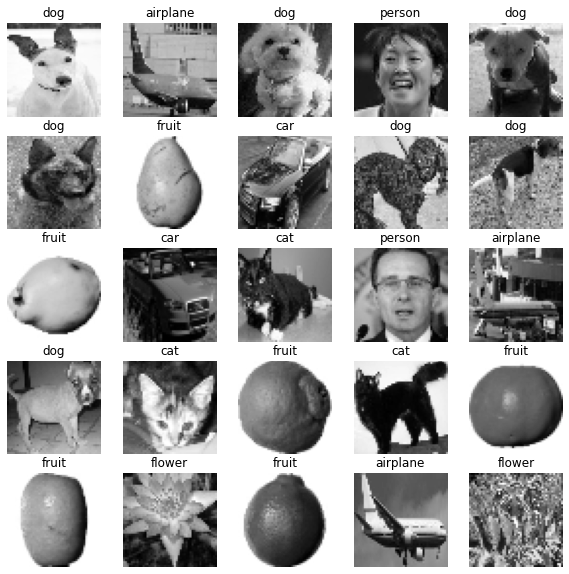

In [ ]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
show_batch(X,y)

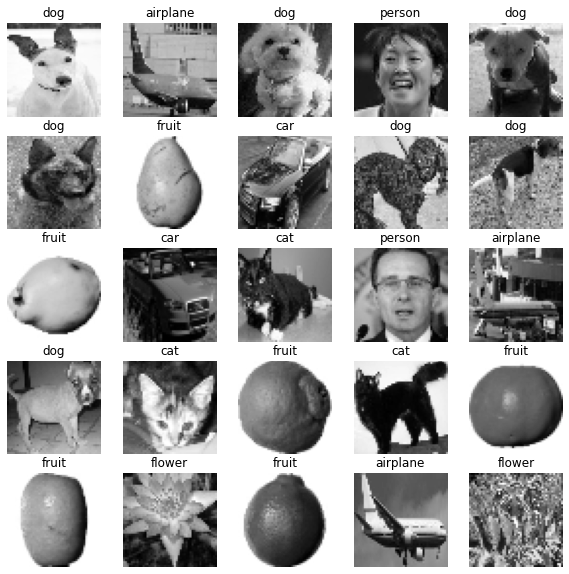

In [ ]:
show_batch_predicted(X)

In [ ]:
!pip install pyngrok

     |████████████████████████████████| 745 kB 5.0 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=9c0ca5396ea7a6b7b764cb24706f652ff2250c1119213dbc3dcf1c62c0a3c1af
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [ ]:
pip freeze > requirement.txt

In [ ]:
!pip install streamlit

In [ ]:
pip install pillow

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf



@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('Natural_Images_classifier.h5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # image Classification
         """
         )

file = st.file_uploader("Please upload an file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
    
        size = (64,128)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Overwriting app.py


In [ ]:
!ngrok authtoken 27mOZLQPhbhaKoMWKAEJ1uL14aS_52Nyg4u82cfZGo72sBKFd

In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
from pyngrok import ngrok
url=ngrok.connect(port=8505)

t=2022-04-14T18:36:37+0530 lvl=warn msg="can't bind default web address, trying alternatives" obj=web addr=127.0.0.1:4040
t=2022-04-14T18:36:38+0530 lvl=eror msg="failed to auth" obj=tunnels.session err="Your account is limited to 1 simultaneous ngrok agent session.\nActive ngrok agent sessions in region 'us':\n  - ts_27mvZ1bKggiNuM9krDs50bjxBHE (103.91.121.138)\r\n\r\nERR_NGROK_108\r\n"
t=2022-04-14T18:36:38+0530 lvl=eror msg="failed to reconnect session" obj=csess id=508d671f480a err="Your account is limited to 1 simultaneous ngrok agent session.\nActive ngrok agent sessions in region 'us':\n  - ts_27mvZ1bKggiNuM9krDs50bjxBHE (103.91.121.138)\r\n\r\nERR_NGROK_108\r\n"
t=2022-04-14T18:36:38+0530 lvl=eror msg="session closing" obj=tunnels.session err="Your account is limited to 1 simultaneous ngrok agent session.\nActive ngrok agent sessions in region 'us':\n  - ts_27mvZ1bKggiNuM9krDs50bjxBHE (103.91.121.138)\r\n\r\nERR_NGROK_108\r\n"
t=2022-04-14T18:36:38+0530 lvl=eror msg="terminatin

PyngrokNgrokError: The ngrok process errored on start: Your account is limited to 1 simultaneous ngrok agent session.\nActive ngrok agent sessions in region 'us':\n  - ts_27mvZ1bKggiNuM9krDs50bjxBHE (103.91.121.138)\r\n\r\nERR_NGROK_108\r\n.

In [ ]:
!streamlit run streamlit_host.py